### Import necessary libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Load dataset and Feature Engineering

In [20]:
# Load dataset
df = pd.read_csv("btc_1d_data_2018_to_2025.csv")

# Convert timestamps to datetime
df['Open time'] = pd.to_datetime(df['Open time'])
df.set_index('Open time', inplace=True)

# Feature Engineering
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['High_Low_Diff'] = df['High'] - df['Low']
df['Volatility'] = df['High'] / df['Low']
df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean()
df['RSI_14'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(window=14).mean()))
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['Bollinger_Upper'] = df['Close'].rolling(window=20).mean() + 2 * df['Close'].rolling(window=20).std()
df['Bollinger_Lower'] = df['Close'].rolling(window=20).mean() - 2 * df['Close'].rolling(window=20).std()
df.dropna(inplace=True)

In [21]:
print(df.describe())

                Open           High            Low          Close  \
count    2588.000000    2588.000000    2588.000000    2588.000000   
mean    29817.696055   30504.410100   29087.694428   29847.996294   
std     24294.204173   24787.421903   23777.058507   24319.968615   
min      3211.710000    3276.500000    3156.260000    3211.720000   
25%      9057.002500    9249.747500    8758.250000    9057.365000   
50%     23227.845000   23800.000000   22747.890000   23236.610000   
75%     44173.137500   45494.000000   43174.257500   44212.952500   
max    106143.820000  108353.000000  105321.490000  106143.820000   

              Volume  Quote asset volume  Number of trades  \
count    2588.000000        2.588000e+03      2.588000e+03   
mean    70793.192160        1.826425e+09      1.748935e+06   
std     80618.065148        2.012491e+09      2.101240e+06   
min       663.372320        1.177017e+07      1.241700e+04   
25%     29745.830521        3.957105e+08      4.331600e+05   
50%   

In [22]:
# Select relevant features for prediction
features = ['MA_7', 'MA_30', 'High_Low_Diff', 'Volatility', 'Volume', 'Number of trades', 'EMA_14', 'RSI_14', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower']
data = df[features].values
target = df['Close'].values

# Normalize data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler_X.fit_transform(data)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

## Exploratory Data Analysis

### Bitcoin Closing Price Distribution

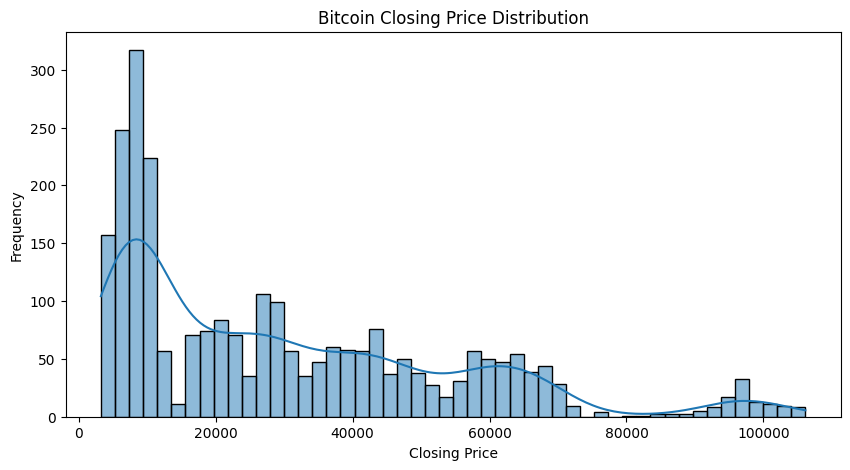

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Close'], bins=50, kde=True)
plt.title("Bitcoin Closing Price Distribution")
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.show()


### Bitcoin Closing Price Over Time

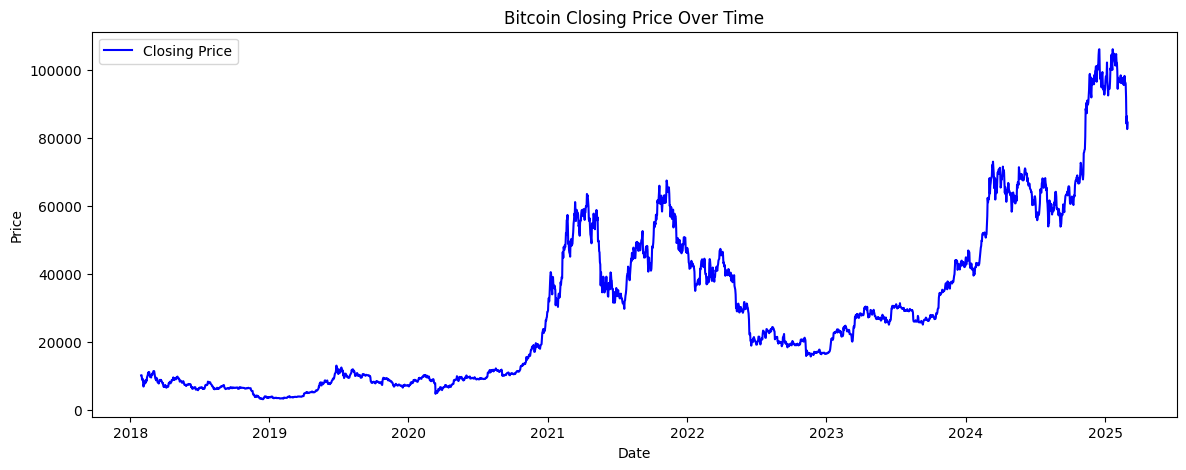

In [24]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'], label="Closing Price", color='blue')
plt.title("Bitcoin Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


### Bitcoin Closing Price with Moving Averages

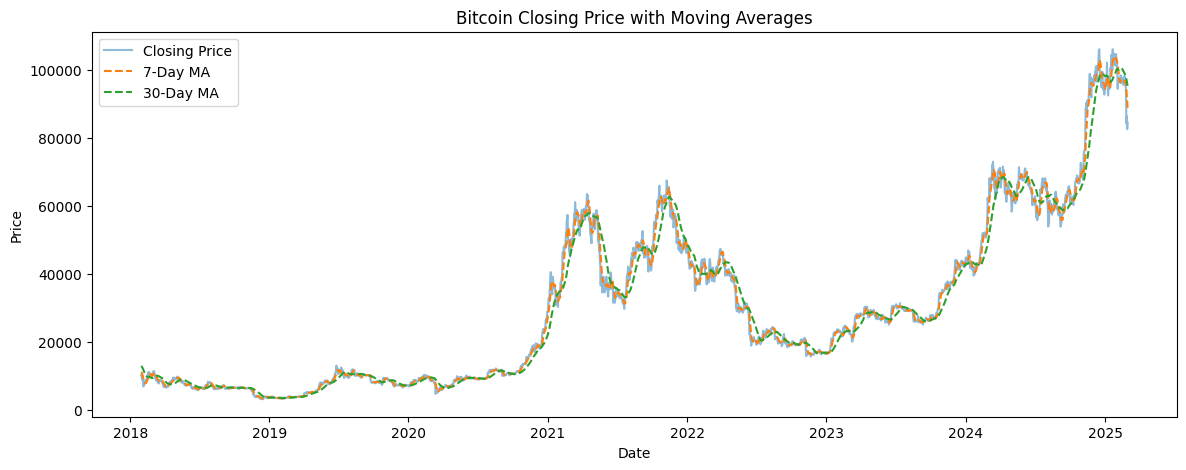

In [25]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'], label="Closing Price", alpha=0.5)
plt.plot(df.index, df['MA_7'], label="7-Day MA", linestyle="dashed")
plt.plot(df.index, df['MA_30'], label="30-Day MA", linestyle="dashed")
plt.title("Bitcoin Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

### Building Model

In [36]:
# Apply PLS-SEM for feature selection
pls = PLSRegression(n_components=8)
pls.fit(data_scaled, target_scaled.ravel())
data_pls = pls.transform(data_scaled)

# Split into training and testing sets
train_size = int(len(data_pls) * 0.8)
X_train, X_test = data_pls[:train_size], data_pls[train_size:]
y_train, y_test = target_scaled[:train_size], target_scaled[train_size:]

# Build ANN model
model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(256),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='linear')
])

C:\Users\iamai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\iamai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### Model Training

In [37]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train the model with Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.9681 - val_loss: 0.0208 - learning_rate: 5.0000e-04
Epoch 2/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8705 - val_loss: 0.0799 - learning_rate: 5.0000e-04
Epoch 3/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5553 - val_loss: 0.0502 - learning_rate: 5.0000e-04
Epoch 4/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4246 - val_loss: 0.0358 - learning_rate: 5.0000e-04
Epoch 5/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3349 - val_loss: 0.0541 - learning_rate: 5.0000e-04
Epoch 6/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2465 - val_loss: 0.0360 - learning_rate: 5.0000e-04
Epoch 7/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1907 - val_loss: 0.0160 - learning_rate: 5.0000e-04
Epoch 8/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1467 - val_loss: 0.0191 - learning_rate: 5.0000e-04
Epoch 9/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1238 - val_loss: 

### Prediction & Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Absolute Error (MAE): 1577.180947604971
Mean Squared Error (MSE): 5426739.361161372
Root Mean Squared Error (RMSE): 2329.536297455219
R-squared (R2): 0.9873879018167554


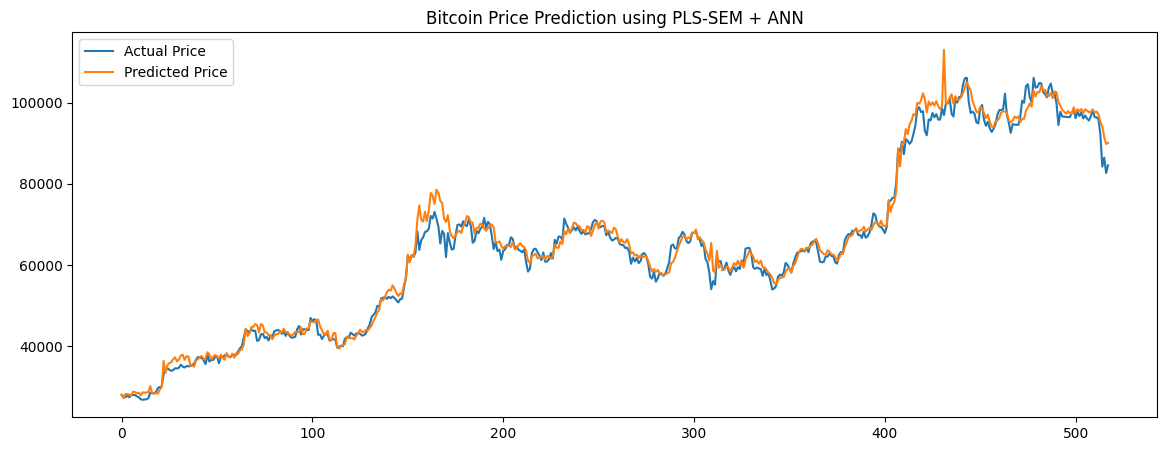

In [38]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Plot results
plt.figure(figsize=(14,5))
plt.plot(y_test, label="Actual Price")
plt.plot(y_pred, label="Predicted Price")
plt.legend()
plt.title("Bitcoin Price Prediction using PLS-SEM + ANN")
plt.show()

### Residual Distribution

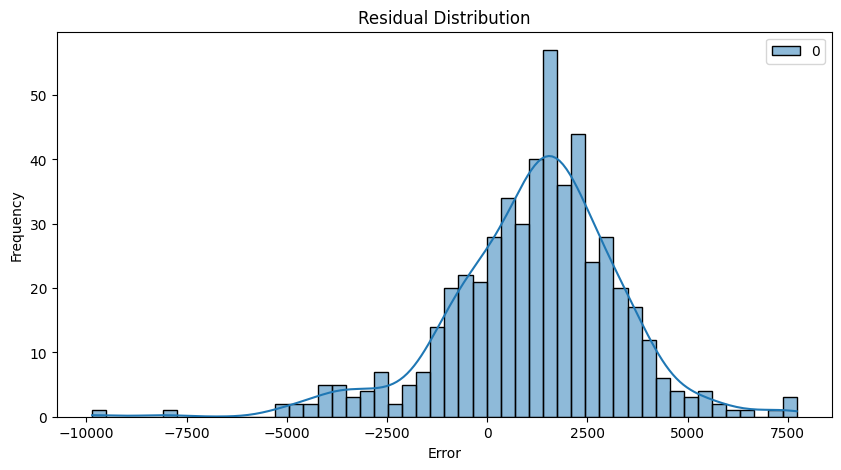

In [29]:
import seaborn as sns
import tensorflow as tf
# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

### Boxplot of Residuals

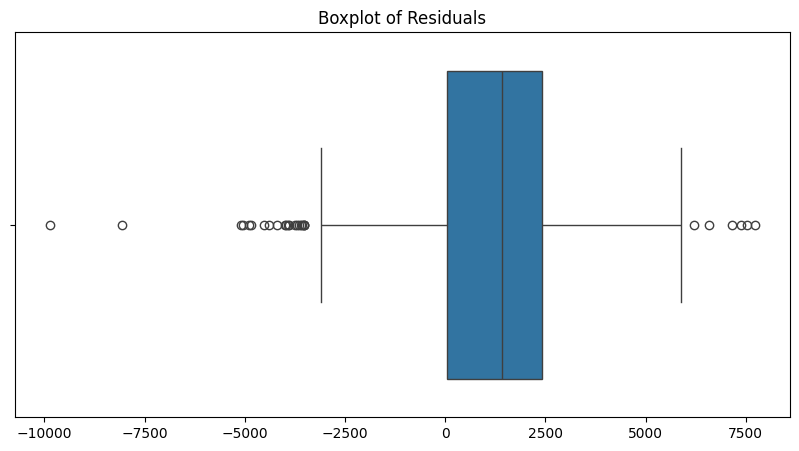

In [30]:
# Error Histogram
plt.figure(figsize=(10, 5))
sns.boxplot(x=residuals.flatten())
plt.title("Boxplot of Residuals")
plt.show()

### Feature Importance from PLS-SEM

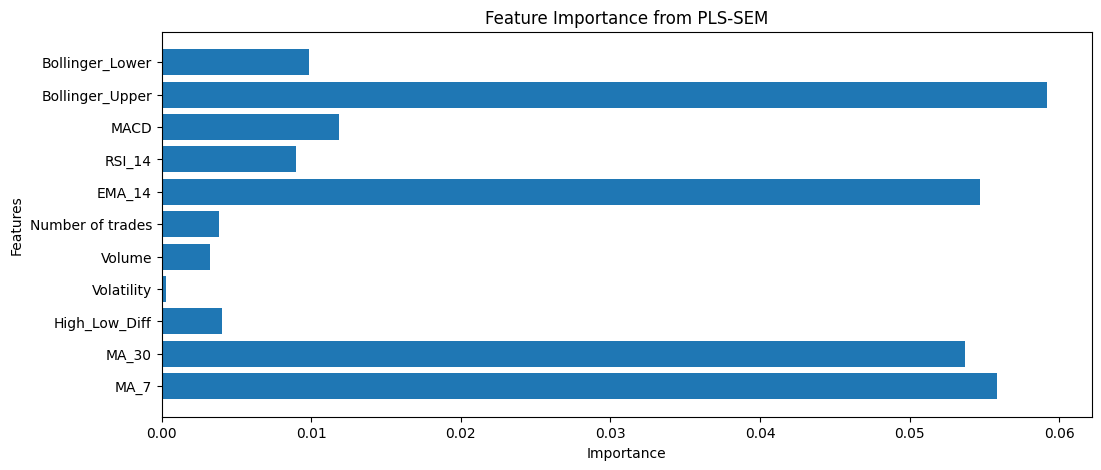

In [31]:
# Feature Importance Plot from PLS-SEM
importance = np.abs(pls.coef_).ravel()
plt.figure(figsize=(12, 5))
plt.barh(features, importance)
plt.title("Feature Importance from PLS-SEM")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

### Autocorrelation of Residuals

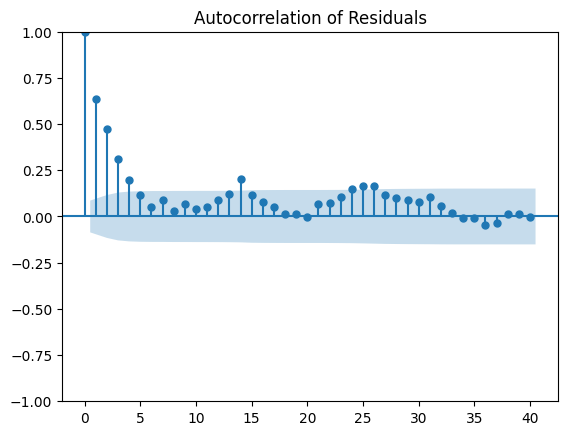

In [32]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("Autocorrelation of Residuals")
plt.show()


In [33]:
# Save the trained model
model.save("bitcoin_price_model.h5")

In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,149 (524.02 KB)

 Trainable params: 44,417 (173.50 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 88,836 (347.02 KB)

In [35]:
# Create DataFrame for visualization
train_test_df = pd.DataFrame({
    "Set": ["Training", "Testing"],
    "Samples": [len(X_train), len(X_test)]
})

# Display the table
print(train_test_df.to_string(index=False))


     Set  Samples
Training     2070
 Testing      518
